In [1]:
import tomllib

import ehc_sn as ehc
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output, display

import maces as spnav_maces

In [2]:
with open("configurations/navigation_network.toml", "rb") as f:
    data = tomllib.load(f)

In [3]:
parameters = ehc.Parameters.model_validate(data)
model = ehc.EHCNetwork(p=parameters)
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): EHCNetwork(
    (mapping): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(10., device='cuda:0'), tau_mem_inv=tensor(4.5000, device='cuda:0'), v_leak=tensor(-40., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
    (inhibitory): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(10., device='cuda:0'), tau_mem_inv=tensor(4.5000, device='cuda:0'), v_leak=tensor(-50., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
    (embedding): EILayer(
      (neurons): BaseLayer(p=LI

In [4]:
decoders = [ehc.decoders.HannDecoder(window_length=100) for _ in range(2)]

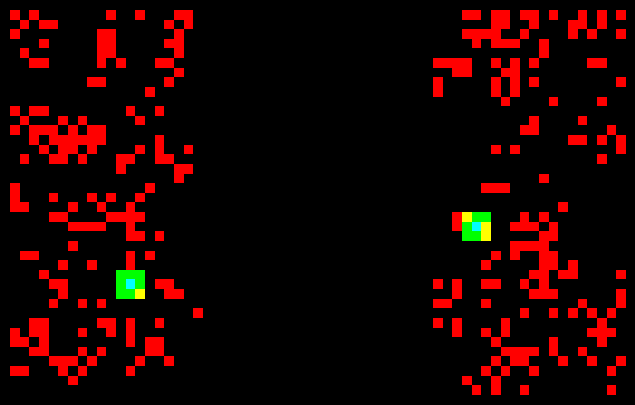

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
maces = [spnav_maces.random(size=(40, 20), num_points=200) for _ in range(2)]

for i, mace in enumerate(maces):
    agent_position = spnav_maces.free(mace)  # Get a free position for the agent
    near_area = spnav_maces.near(mace, agent_position)  # Get the near area around the agent

    # Combine mace, agent position, and near area for visualization
    spnav_maces.plot(mace, position=agent_position, near_area=near_area, ax=ax[i])

plt.show()

In [6]:
def signal_loader(n, mace: torch.Tensor, decay=0.3):
    position = spnav_maces.free(mace)
    for _ in range(n):
        yield spnav_maces.sensor(mace, position, decay).flatten().to(ehc.device)
        # Next position should be near previous, not touching the wall
        position = spnav_maces.random_near(mace, position)

In [7]:
memory_1 = torch.randint(0, 2, size=[800], device=ehc.device).detach()

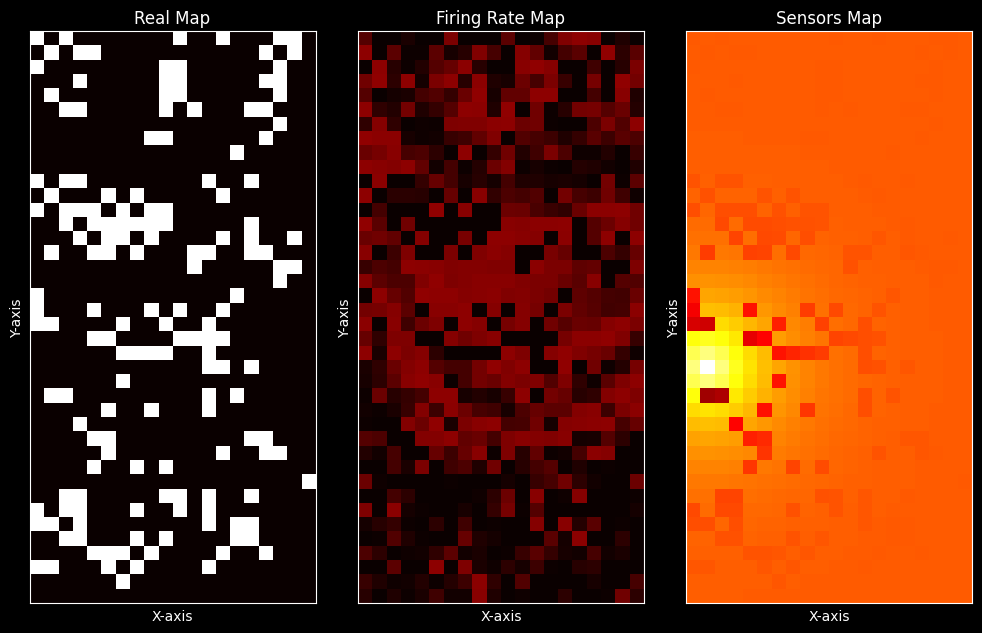

In [8]:
# Initializing the figure for the animation
zeros = torch.zeros(40, 20).cpu().numpy()  # Initial data for the image
fig, ax = plt.subplots(1, 3, figsize=(10, 8))
imgmap = ax[0].imshow(maces[0].cpu().numpy(), cmap="hot", vmin=0.0, vmax=1.0)
imgfig = ax[1].imshow(zeros.copy(), cmap="hot", vmin=0.0, vmax=0.1)
imgsen = ax[2].imshow(zeros.copy(), cmap="hot", vmin=-1.0, vmax=1.0)
fig.tight_layout()

# Set the titles and labels for the cognitive map figure
ax[0].set_title("Real Map")
ax[0].set_xlabel("X-axis"), ax[0].set_ylabel("Y-axis")
ax[0].set_xticks([]), ax[0].set_yticks([])

# Set the titles and labels for the cognitive map figure
ax[1].set_title("Firing Rate Map")
ax[1].set_xlabel("X-axis"), ax[2].set_ylabel("Y-axis")
ax[1].set_xticks([]), ax[2].set_yticks([])

# Set the titles and labels for the cognitive map figure
ax[2].set_title("Sensors Map")
ax[2].set_xlabel("X-axis"), ax[1].set_ylabel("Y-axis")
ax[2].set_xticks([]), ax[1].set_yticks([])


# Run simulation and update the figure
for sensors in signal_loader(500, maces[0]):

    # Get the next output from the model
    cmap, embedding = model(1.0 * sensors, 1.0 * memory_1)
    sensors = sensors.reshape(40, 20)  # Reshape to match the image size

    # Update the image data
    cmap = decoders[0](cmap).reshape(40, 20)  # Reshape to match the image size
    imgfig.set_data(cmap.cpu().numpy())  # Update the image data

    # Update the sensors data
    embedding = decoders[1](embedding).reshape(40, 20)  # Reshape to match the image size
    imgsen.set_data(sensors.cpu().numpy())  # Update the embedding data

    # Clear the previous output and display the updated figure
    clear_output(wait=True)
    display(fig)  # Display the updated figure
    plt.pause(0.01)  # Pause to allow the figure to update

pass  # This is a placeholder to avoid display errors

In [9]:
for sensors_1 in signal_loader(4000, maces[0]):
    cmap, embedding = model(10.0 * sensors_1, 10.0 * memory_1)

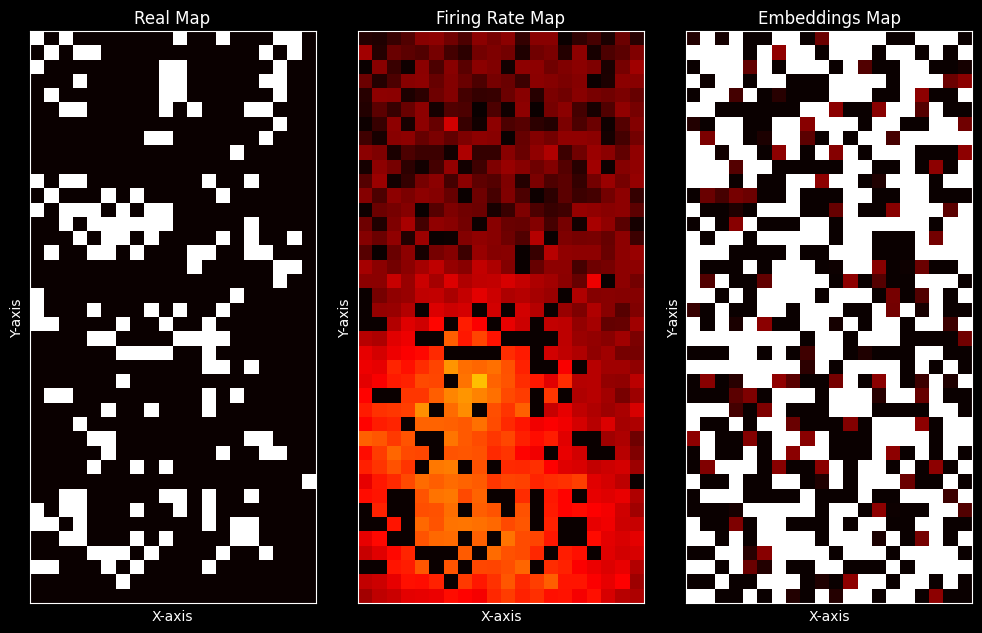

In [10]:
# Initializing the figure for the animation
zeros = torch.zeros(40, 20).cpu().numpy()  # Initial data for the image
fig, ax = plt.subplots(1, 3, figsize=(10, 8))
imgmap = ax[0].imshow(maces[0].cpu().numpy(), cmap="hot", vmin=0.0, vmax=1.0)
imgfig = ax[1].imshow(zeros.copy(), cmap="hot", vmin=0.0, vmax=0.1)
imgemb = ax[2].imshow(zeros.copy(), cmap="hot", vmin=0.0, vmax=0.1)
fig.tight_layout()

# Set the titles and labels for the cognitive map figure
ax[0].set_title("Real Map")
ax[0].set_xlabel("X-axis"), ax[0].set_ylabel("Y-axis")
ax[0].set_xticks([]), ax[0].set_yticks([])

# Set the titles and labels for the cognitive map figure
ax[1].set_title("Firing Rate Map")
ax[1].set_xlabel("X-axis"), ax[2].set_ylabel("Y-axis")
ax[1].set_xticks([]), ax[2].set_yticks([])

# Set the titles and labels for the cognitive map figure
ax[2].set_title("Embeddings Map")
ax[2].set_xlabel("X-axis"), ax[1].set_ylabel("Y-axis")
ax[2].set_xticks([]), ax[1].set_yticks([])


# Run simulation and update the figure
for sensors in signal_loader(100, maces[0]):

    # Get the next output from the model
    cmap, embedding = model(1.0 * sensors, 1.0 * memory_1)
    sensors = sensors.reshape(40, 20)  # Reshape to match the image size

    # Update the image data
    cmap = decoders[0](cmap).reshape(40, 20)  # Reshape to match the image size
    imgfig.set_data(cmap.cpu().numpy())  # Update the image data

    # Update the sensors data
    embedding = decoders[1](embedding).reshape(40, 20)  # Reshape to match the image size
    imgemb.set_data(embedding.cpu().numpy())  # Update the embedding data

    # Clear the previous output and display the updated figure
    clear_output(wait=True)
    display(fig)  # Display the updated figure
    plt.pause(0.01)  # Pause to allow the figure to update

pass  # This is a placeholder to avoid display errors